In [1]:
#!/usr/bin/env python
# coding: utf-8

import argparse
import os
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import pickle as pkl
import pytz
import sys
sys.path.append('../')

from utils import stats

from dask.diagnostics import ProgressBar
ProgressBar().register()

from paths_usa import *

import matplotlib.pyplot as plt
from refuelplot import *
setup()
sns.set_style("darkgrid")

In [2]:
GWA = 2
results_pathg = results_path

In [3]:
# define function for preparing capacity time series
def get_cap_df(cap,comdate):
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    # if only years given for commissioning dates -> gradual capacity increase over year, full capacity at end of year
    if type(cap_cum.index.values[0]) == np.int64:
        cap_cum.index = [np.datetime64(str(int(year))+"-12-31 23:00:00") for year in cap_cum.index.values]
        # create yearly dates at yearends
        drcc = pd.date_range(np.datetime64('1999-12-31 23:00:00'),
                             np.datetime64('2019-12-31 23:00:00'),freq= 'y')
        cap_cum = pd.Series(drcc.map(cap_cum),index = drcc)
        # if first year emtpy: either year before or 0 if nothing before
        if(sum(com.index<2000) > 0):
            cap_cum[0] = com.cumsum()[com.index<2000].max()
        else:
            cap_cum[0] = 0
        # if missing years -> put capacity of year before
        cap_cum = cap_cum.ffill()
    dr = pd.date_range('1/1/2000','31/12/2019 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()
    if type(comdate[0]) == np.int64:
        return(cap_ts.interpolate(method='linear'))
    else:
        return(cap_ts.fillna(method='ffill'))
    

In [4]:
### Prepare wind park data - Installed capacities

# prepare states and regions of USA
states = ['USA','NewEng','CT','ME','MA','NH','RI','VT','MidAtl','NJ','NY','PA','ENC','IL','IN','MI','OH','WI','WNC','IA','KS','MN',
'MO','NE','ND','SD','SouAtl','DE','DC','FL','GA','MD','NC','SC','VA','WV','ESC','AL','KY','MS','TN','WSC','AR','LA','OK',
'TX','Mou','AZ','CO','ID','MT','NV','NM','UT','WY','PacCon','CA','OR','WA','PacNon','AK','HI']

MidAtl = ['NY','NJ','PA'] # ['NY','NJ','PA','DE','MD','WA','VA','WV'] right states according to wikipedia, graphical analysis showed that only three states
SouAtl = ['DE','MD','VA','WV','NC','SC','GA','FL','DC']
PacCon = ['CA','OR','WA']
PacNon = ['AK','HI'] # parts of AK missing, but only in AK, not in PacNon
ENC = ['IL','IN','MI','OH','WI']
WNC = ['IA','KS','MN','MS','NE','ND','SD'] # forgot Kansas in earlier version!
ESC = ['AL','KY','MS','TN']
WSC = ['AR','LA','OK','TX']
Mou = ['CO','WY','UT','NM','NV','ID','AZ','MT']
NewEng = ['CT','NH','ME','MA','RI','VT']


# get BPA windparks
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# get windturbine locations/names
windturbines = pd.read_csv(usa_path+"/uswtdb_v2_3_20200109.csv",delimiter=',')
wt = pd.read_csv(usa_path + "/turbine_data.csv",parse_dates = ['time'])
# get aggregated turbine data
turb_mer = pd.read_csv(usa_path + "/turbine_data_mer.csv",parse_dates = ['commissioning']).drop('Unnamed: 0',axis=1)
# find where BPA wind turbines are
pBPA = pd.DataFrame({'p': [park in BPA_parks.name.values for park in windturbines[windturbines.t_state!='GU'].p_name.values]})
# find where New England wind turbines are
NE_states = ['CT','NH','ME','MA','RI','VT']
NE_turbines = turb_mer[[state in ['CT','NH','ME','MA','RI','VT'] for state in turb_mer.state]]
# get capacities time series for all regions
cap_usa = get_cap_df(turb_mer.capacity.values,
                     pd.DatetimeIndex(turb_mer.commissioning).year.values).tz_localize('UTC').tz_convert('US/Central')
cap_IA = get_cap_df(turb_mer.capacity[turb_mer.state=='IA'].values,
                    pd.DatetimeIndex(turb_mer.commissioning[turb_mer.state=='IA']).year.values).tz_localize('UTC').tz_convert('US/Central')
cap_TX = get_cap_df(turb_mer.capacity[turb_mer.state=='TX'].values,
                    pd.DatetimeIndex(turb_mer.commissioning[turb_mer.state=='TX']).year.values).tz_localize('UTC').tz_convert('US/Central')
cap_BPA = get_cap_df(wt.capacity[pBPA.p].values,
                     pd.DatetimeIndex(wt.time[pBPA.p]).year.values).tz_localize('UTC')
cap_NE = get_cap_df(NE_turbines.capacity.values,
                    pd.DatetimeIndex(NE_turbines.commissioning).year.values).tz_localize('UTC').tz_convert('US/Eastern')

# get capacities of all regions in USA
cap_states = pd.DataFrame()
for state in np.array(states)[[len(s)==2 for s in states]]:
    if len(turb_mer.capacity[turb_mer.state==state].values)>0:
        cap_s = get_cap_df(turb_mer.capacity[turb_mer.state==state].values,
                           pd.DatetimeIndex(turb_mer.commissioning[turb_mer.state==state]).year.values).tz_localize('UTC').tz_convert('US/Central')
        cap_states = pd.concat([cap_states,cap_s],axis=1)
cap_states.columns = np.array(states)[[s in turb_mer.state.unique() for s in states]]

cap_NewEng = cap_states[np.array(NewEng)[[s in turb_mer.state.unique() for s in NewEng]]].fillna(0).sum(axis=1)
cap_MidAtl = cap_states[np.array(MidAtl)[[s in turb_mer.state.unique() for s in MidAtl]]].fillna(0).sum(axis=1)
cap_SouAtl = cap_states[np.array(SouAtl)[[s in turb_mer.state.unique() for s in SouAtl]]].fillna(0).sum(axis=1)
cap_PacCon = cap_states[np.array(PacCon)[[s in turb_mer.state.unique() for s in PacCon]]].fillna(0).sum(axis=1)
cap_PacNon = cap_states[np.array(PacNon)[[s in turb_mer.state.unique() for s in PacNon]]].fillna(0).sum(axis=1)
cap_ENC = cap_states[np.array(ENC)[[s in turb_mer.state.unique() for s in ENC]]].fillna(0).sum(axis=1)
cap_WNC = cap_states[np.array(WNC)[[s in turb_mer.state.unique() for s in WNC]]].fillna(0).sum(axis=1)
cap_ESC = cap_states[np.array(ESC)[[s in turb_mer.state.unique() for s in ESC]]].fillna(0).sum(axis=1)
cap_WSC = cap_states[np.array(WSC)[[s in turb_mer.state.unique() for s in WSC]]].fillna(0).sum(axis=1)
cap_Mou = cap_states[np.array(Mou)[[s in turb_mer.state.unique() for s in Mou]]].fillna(0).sum(axis=1)

# get IRENA capacities for observed generation USA
caps_irena = pd.read_csv(usa_path + '/IRENA_caps.csv').iloc[:,3:].T
caps_irena.columns = ['caps_MW']
# cumulative capacity
capc = caps_irena.caps_MW.str.replace(' ','').astype(np.int64).values
# added capacity
cap = np.append(capc[0],capc[1:]-capc[:-1])
comdate = caps_irena.index.values.astype(np.int64)
# get capacities time series
cap_usaIRENA = get_cap_df(cap,comdate).tz_localize('UTC').tz_convert('US/Central')

# aggregate daily or monthly where needed
cap_usam = cap_usa.resample('M').sum()
cap_IAm = cap_IA.resample('M').sum()
cap_TXm = cap_TX.resample('M').sum()
cap_TXd = cap_TX.resample('D').sum()
cap_TXh = cap_TX
cap_BPAm = cap_BPA.resample('M').sum()
cap_BPAd = cap_BPA.resample('D').sum()
cap_BPAh = cap_BPA
cap_NEm = cap_NE.resample('M').sum()
cap_usaIm = cap_usaIRENA.resample('M').sum()

cap_statesm = cap_states.resample('M').sum()
cap_NewEngm = cap_NewEng.resample('M').sum()
cap_MidAtlm = cap_MidAtl.resample('M').sum()
cap_SouAtlm = cap_SouAtl.resample('M').sum()
cap_PacConm = cap_PacCon.resample('M').sum()
cap_PacNonm = cap_PacNon.resample('M').sum()
cap_ENCm = cap_ENC.resample('M').sum()
cap_WNCm = cap_WNC.resample('M').sum()
cap_ESCm = cap_ESC.resample('M').sum()
cap_WSCm = cap_WSC.resample('M').sum()
cap_Moum = cap_Mou.resample('M').sum()

In [5]:
### Analysis capacity factors

## USA monthly
# Load production data
# Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201903&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_for_wind.csv",header=4)
# arrange data
# tidy data
prod_USAm = prod_USAm[[': all sectors' in s for s in prod_USAm.description]].replace('--',np.nan).replace('NM',np.nan).drop(['units','source key'],axis=1)
prod_USAm['description'] = prod_USAm.description.str.replace(' : all sectors','')
# make production numeric
prod_USAm.iloc[:,1:] = prod_USAm.iloc[:,1:].astype(np.float)
# transpose to datetime as index and regions as columns
prod_USAm = prod_USAm.set_index('description').transpose()
# convert dates to datetime format
dates = prod_USAm.reset_index()['index'].str.split(expand=True)
prod_USAm.index = pd.to_datetime(['{}-{}-01'.format(y, m) for y, m in zip(dates[1].astype(str), dates[0].astype(str))])
# cut after 2019
prod_USAm = prod_USAm[prod_USAm.index < np.datetime64("2020-01-01")].tz_localize('US/Central')
# adapt column names
prod_USAm.columns = states
# Prepare simulated data
# load data
wpE_GWA = xr.open_dataset(results_pathg+"/windpower_USA_ERA5_GWA.nc").to_dataframe()
# merge data
wp_USA = wpE_GWA.tz_localize('UTC').tz_convert('US/Central')
wp_USA.columns = ['ERA5 GWA2']
# aggregate monthly
wp_USAm = wp_USA.resample('M').sum()
# combine data and calculate capacity factors
cf_USAm = pd.concat([wp_USAm.div(cap_usam,axis=0),
                      (prod_USAm.resample('M').sum()['USA']*10**6/(cap_usaIm*10**3))],axis=1).dropna()
cf_USAm.columns = np.append(wp_USAm.columns,'oserved generation')

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


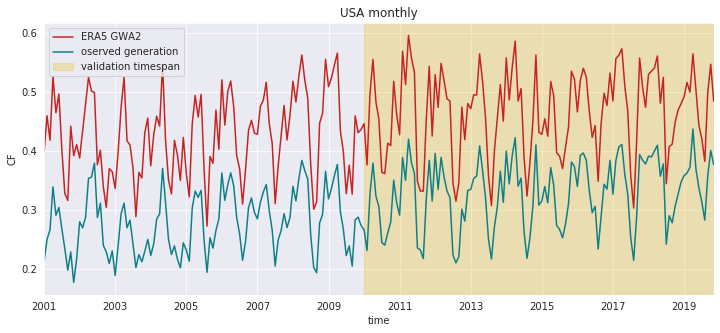

In [36]:
cf_USAm.plot(figsize=(12,5))
plt.axvspan('2010', '2020', alpha=0.3,label='validation timespan',color=COLORS[2])
plt.xlabel('time')
plt.ylabel('CF')
plt.title('USA monthly')
plt.legend()
plt.savefig(results_path + '/TS_plots/USA.png')

In [6]:
## regions monthly
# Prepare simulated data
# load data
wpE_GWA = xr.open_dataset(results_pathg+"/windpower_states_ERA5_GWA.nc").to_dataframe()
# Errors:
# - ESC: lots of 0 until 2005
# - NewEng: until 2007 wp_obs low and nearly constant
# prepare stats dataframes
stats_regionsm = pd.DataFrame()
stats_regionsm_r = pd.DataFrame()
# define order of regions, states in regions and capacities
regions = prod_USAm.columns[[len(r)>2 for r in prod_USAm.columns]][1:]
regions.values.sort()
states_reg = [ENC,ESC,MidAtl,Mou,NewEng,PacCon,PacNon,SouAtl,WNC,WSC]
caps_reg = [cap_ENCm,cap_ESCm,cap_MidAtlm,cap_Moum,cap_NewEngm,cap_PacConm,cap_PacNonm,cap_SouAtlm,cap_WNCm,cap_WSCm]

In [53]:
keepregions = ['ENC','MidAtl','Mou','PacCon','SouAtl','WNC','WSC']

In [54]:
def plot_region(region,ax=None,legend=False):
    state_reg = states_reg[np.where(regions==region)[0][0]]
    cap_regm = caps_reg[np.where(regions==region)[0][0]]
    wpE_GWA_reg = wpE_GWA.loc[state_reg].wp.unstack().transpose().sum(axis=1)
    prod_regm = prod_USAm[region]
    # merge data
    wp_reg = pd.DataFrame(wpE_GWA_reg).tz_localize('UTC').tz_convert('US/Central')
    wp_reg.columns = ['ERA5 GWA2']
    # aggregate monthly
    wp_regm = wp_reg.resample('M').sum()
    # combine data and calculate capacity factors
    cf_regm = pd.concat([wp_regm.div(cap_regm,axis=0),
                          (prod_regm.resample('M').sum()*10**6/cap_regm)],axis=1).dropna()
    cf_regm.columns = np.append(wp_regm.columns,'observed generation')
    if ax == None:
        cf_regm.plot(figsize=(12,5))
        plt.xlabel('time')
        plt.ylabel('CF')
        plt.title(region+' monthly')
    else:
        if legend == True:
            cf_regm.plot(figsize=(24,25),
                         ax=ax,title=region+' monthly').legend(bbox_to_anchor=(1.05, 1.0),loc='upper left')
            ax.set_xlabel('time')
            ax.set_ylabel('CF')
        else:
            cf_regm.plot(figsize=(24,25),ax=ax,legend=False,title=region+' monthly')
            ax.set_xlabel('time')
            ax.set_ylabel('CF')
    if region in keepregions:
        ax.axvspan('2010','2020',alpha=0.3,label='validation timespan',color=COLORS[2])

In [ ]:
regions.values.sort()
fig, axs = plt.subplots(5, 2)
for i in range(10):
    if(i==8):
        leg = True
    else:
        leg = False
    plot_region(regions[i],ax=axs[i%5,int(i/5)],legend=leg)
plt.savefig(results_path + '/TS_plots/regions.png')

In [6]:
## states monthly
# Prepare simulated data
# load data
wpE_GWA = xr.open_dataset(results_pathg+"/windpower_states_ERA5_GWA.nc").to_dataframe()
stats_statesm = pd.DataFrame()
stats_statesm_r = pd.DataFrame()
# drop states that have no data
prod_USAm = prod_USAm[prod_USAm.columns[(~prod_USAm.isna()).sum()!=0]]
states_USAm = prod_USAm.columns[[len(s)==2 for s in prod_USAm.columns]]

In [8]:
timespan = {'MA':['2012','2020'],
            'RI':['2017','2020'],
            'VT':['2012','2020'],
            'OH':['2012','2020'],
            'NJ':['2014','2018'],
            'NE':['2014','2020'],
            #'MI':['2009','2020'],
            #'WI':['2001','2016'],
            #'ND':['2005','2020']}
            'WI':['2010','2016']}
keepstate = ['AZ','CA','CO','HI','IA','ID','IN','KS','MD','ME','MN','MO','MT',
             'NH','NM','NV','NY','OK','OR','PA','TX','UT','WA','WV','WY'] + ['MI','ND']

In [9]:
def plot_state(state,ax=None,legend=False):
    wp_st = pd.DataFrame(wpE_GWA.wp.loc[state]).tz_localize('UTC').tz_convert('US/Central')
    wp_st.columns = ['ERA5 GWA2']
    # aggregate monthly
    wp_stm = wp_st.resample('M').sum()
    # combine data and calculate capacity factors
    cf_stm = pd.concat([wp_stm.div(cap_statesm[state],axis=0),
                          (prod_USAm.resample('M').sum()[state]*10**6/(cap_statesm[state]))],axis=1).replace(np.inf, np.nan).dropna()[1:]
    cf_stm.columns = np.append(wp_stm.columns,'observed generation')
    if ax == None:
        cf_stm.plot(figsize=(12,5))
        plt.xlabel('time')
        plt.ylabel('CF')
        plt.title(state+' monthly')
    else:
        if legend == True:
            cf_stm.plot(figsize=(24,35),
                         ax=ax,title=state+' monthly').legend(bbox_to_anchor=(1.05, 1.0),loc='upper left')
            ax.set_xlabel('time')
            ax.set_ylabel('CF')
        else:
            cf_stm.plot(figsize=(24,35),ax=ax,legend=False,title=state+' monthly')
            ax.set_xlabel('time')
            ax.set_ylabel('CF')
    if timespan.get(state):
        ax.axvspan(timespan.get(state)[0],timespan.get(state)[1],
                    alpha=0.3,label='validation timespan',color=COLORS[2])
    if state in keepstate:
        ax.axvspan('2010','2020',alpha=0.3,label='validation timespan',color=COLORS[2])

In [10]:
STATES = np.array(states_USAm)[[s in turb_mer.state.unique() for s in states_USAm]]
STATES.sort()

In [ ]:
fig, axs = plt.subplots(7, 2)
for i in range(14):
    if(i==10):
        leg = True
    else:
        leg = False
    plot_state(STATES[i],ax=axs[i%7,int(i/7)],legend=leg)
plt.savefig(results_path + '/TS_plots/states1.png')

In [ ]:
fig, axs = plt.subplots(7, 2)
for i in range(14,28):
    if(i==24):
        leg = True
    else:
        leg = False
    plot_state(STATES[i],ax=axs[i%7,int(i/7)-2],legend=leg)
plt.savefig(results_path + '/TS_plots/states2.png')

In [ ]:
fig, axs = plt.subplots(7, 2)
for i in range(28,len(STATES)):
    if(i==38):
        leg = True
    else:
        leg = False
    plot_state(STATES[i],ax=axs[i%7,int(i/7)-4],legend=leg)
plt.savefig(results_path + '/TS_plots/states3.png')

In [20]:
## Texas hourly
# Load production data
# Source: http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13424&reportTitle=Hourly%20Aggregated%20Wind%20Output&showHTMLView=&mimicKey
files =  os.listdir(usa_path+"/generation_data/TX_hourly")
for file in files:
    if 'prod_TXh_xl' in globals():
        prod_TXh_xl = pd.concat([prod_TXh_xl,pd.read_excel(usa_path+"/generation_data/TX_hourly/"+file,sheet_name="numbers")],axis=0)
    else:
        prod_TXh_xl = pd.read_excel(usa_path+"/generation_data/TX_hourly/"+file,sheet_name="numbers")
# arrange data - get production data
# and consider daylight saving time and convert timezone to UTC
# Prepare simulated data
prod_TXh = pd.DataFrame({'wp_obs':prod_TXh_xl['Total Wind Output, MW'].values},
                         index = pd.to_datetime(prod_TXh_xl.Date.values)).tz_localize('US/Central',ambiguous='infer').tz_convert('UTC')
# remove duplicates
prod_TXh = prod_TXh[~prod_TXh.index.duplicated()]*10**3
# load simulated data
wp_TXE = xr.open_dataset(results_path+"/windpower_states_ERA5.nc").sel(state='TX').drop('state').to_dataframe()
wp_TXE_GWA = xr.open_dataset(results_pathg+"/windpower_states_ERA5_GWA.nc").sel(state='TX').drop('state').to_dataframe()
wp_TXM = xr.open_dataset(results_path+"/windpower_states_MERRA2.nc").sel(state='TX').drop('state').to_dataframe().resample('h').sum() # resample merra because 2019 different format
wp_TXM_GWA = xr.open_dataset(results_pathg+"/windpower_states_MERRA2_GWA.nc").sel(state='TX').drop('state').to_dataframe().resample('h').sum()
# merge
comp_TXh = pd.concat([wp_TXE,wp_TXE_GWA,wp_TXM,wp_TXM_GWA],axis=1)
comp_TXh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']
comp_TXh = comp_TXh.tz_localize('UTC')
# add production data
comp_TXh['wp_obs'] = comp_TXh.index.map(prod_TXh.wp_obs)
comp_TXh = comp_TXh.fillna(method='ffill').dropna() # remove rows before 2016 and one missing value (2016-07-07 17:00:00)
# calculate capacity factor
cf_TXh = comp_TXh.div(cap_TXh.tz_convert('UTC'),axis=0).dropna()

In [ ]:
cf_TXh.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('Texas hourly')
plt.savefig(results_path + '/TS_plots/TXh.png')

Text(0.5, 1.0, 'Texas hourly')

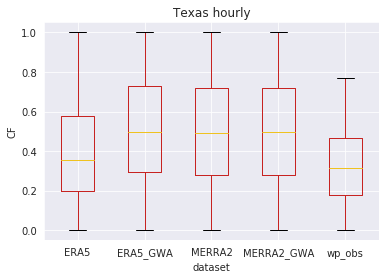

In [19]:
cf_TXh.boxplot()
plt.xlabel('dataset')
plt.ylabel('CF')
plt.title('Texas hourly')

In [22]:
# Texas Daily
# Prepare data
# aggregate per day
comp_TXd = comp_TXh.tz_convert('US/Central').resample('D').sum()
# calculate capacity factors
cf_TXd = comp_TXd.div(cap_TXd,axis=0).dropna()

In [27]:
comp_TXm = comp_TXh.tz_convert('US/Central').resample('M').sum()
cf_TXm = comp_TXm.div(cap_TXm,axis=0).dropna()

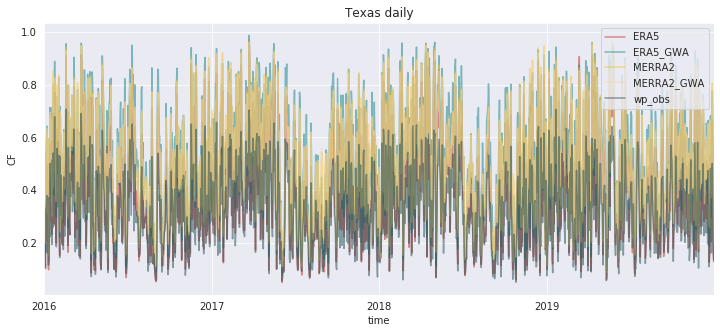

In [23]:
cf_TXd.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('Texas daily')
plt.savefig(results_path + '/TS_plots/TXd.png')

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


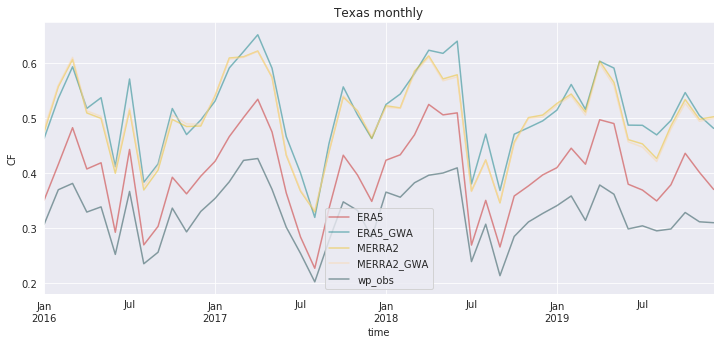

In [28]:
cf_TXm.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('Texas monthly')
plt.savefig(results_path + '/TS_plots/TXm.png')

In [30]:
del(prod_BPA5min)

In [31]:
## BPA hourly + daily + monthly
# Load production data
# Source: https://transmission.bpa.gov/Business/Operations/Wind/  
# arrange data - get production data
# and consider daylight saving time and convert timezone to UTC
# load and prepare production data in convenient format
# for years 2007 to 2010 files are not formatted equally, so define columns to select
col = pd.DataFrame({'dat1':[2,2,3,3],
                    'dat2':[10,11,12,12],
                    'time1':[1,1,1,1],
                    'time2':[9,10,10,10],
                    'lines':[14,16,16,16]},
                   index = ['07','08','09','10'])
# for years 2011 to 2019 only lines are different
lines = pd.DataFrame({'x': [18,18,18,18,18,18,21,19,23]},
                     index = [11,12,13,14,15,16,17,18,19])
for year in ['07','08','09']:
    BPAxl = pd.read_excel(usa_path+"/generation_data/BPA_5min/TotalWindLoad_5Min_"+year+".xls",
                          skiprows=col.lines[year])
    # for first half of year less rows - drop them
    BPAxl_drop = BPAxl.dropna(subset=[BPAxl.columns[1]],axis=0)
    # merge data for first and second half of year in datetime indexed data frame
    BPAxl_dat = pd.DataFrame({'wp_obs':pd.concat([BPAxl_drop.iloc[:,col.dat1[year]],
                                                  BPAxl.iloc[:,col.dat2[year]]]).values},
                             index = pd.concat([pd.to_datetime(BPAxl_drop.iloc[:,col.time1[year]]),
                                                pd.to_datetime(BPAxl.iloc[:,col.time2[year]])]).values)
    # there seems to be some numeric error, therefore round index to minutes
    BPAxl_dat.index = BPAxl_dat.index.round("Min")
    
    # add the timezone and interpolate missing data (a few minutes are missing)
    #   create a dataframe with 5 minute timesteps to match values
    #   this is necessary, as there is lines for hours omitted due to daylight saving
    #   but no additional hours due to duplication of an hour in daylight saving in the second half of the year
    #   therefore the ambiguous argument 'infer' does not work
    #   by mapping the values of this hour are duplicated and then infer works
    ind = pd.date_range(start='1/1/20'+year+' 00:00:00',
                        end='31/12/20'+year+' 23:59:00', freq='5min',tz="US/Pacific")
    ind2 = [i.replace(tzinfo=None) for i in ind]
    BPAdat = pd.DataFrame({'wp_obs':np.nan},
                          index = ind2)
    BPAdat.wp_obs = BPAdat.index.map(BPAxl_dat.wp_obs)
    BPAtz = BPAdat.tz_localize('US/Pacific',ambiguous='infer').interpolate()
    # concatenate years
    if 'prod_BPA5min' in globals():
        prod_BPA5min = pd.concat([prod_BPA5min,BPAtz],axis=0)
    else:
        prod_BPA5min = BPAtz
# year 2010 is the only of the first set of years that actually has data for the duplicate hour
# therefore needs to be handled differently
year = '10'
BPAxl = pd.read_excel(usa_path+"/generation_data/BPA_5min/TotalWindLoad_5Min_"+year+".xls",
                      skiprows=col.lines[year])
BPAxl_drop = BPAxl.dropna(subset=[BPAxl.columns[1]],axis=0)
BPAxl_dat = pd.DataFrame({'wp_obs':pd.concat([BPAxl_drop.iloc[:,col.dat1[year]],
                                              BPAxl.iloc[:,col.dat2[year]]]).values},
                         index = pd.concat([pd.to_datetime(BPAxl_drop.iloc[:,col.time1[year]]),
                                            pd.to_datetime(BPAxl.iloc[:,col.time2[year]])]).values)
BPAtz = BPAxl_dat.tz_localize('US/Pacific',ambiguous='infer').interpolate()
prod_BPA5min = pd.concat([prod_BPA5min,BPAtz],axis=0)
for year in range(11,20):
    # read data from two sheets separately
    BPAxl1 = pd.read_excel(usa_path+"/generation_data/BPA_5min/WindGenTotalLoadYTD_20"+str(year)+".xls",
                           sheet_name="January-June",
                           skiprows=lines.x[year])
    BPAxl2 = pd.read_excel(usa_path+"/generation_data/BPA_5min/WindGenTotalLoadYTD_20"+str(year)+".xls",
                           sheet_name="July-December",
                           skiprows=lines.x[year])
    # merge data for first and second half of year in datetime indexed data frame
    # and add a timezone and interpolate missing values
    BPAdat = pd.DataFrame({'wp_obs':pd.concat([BPAxl1.iloc[:,2],BPAxl2.iloc[:,2]]).values},
                          index = pd.concat([pd.to_datetime(BPAxl1.iloc[:,0]),
                                             pd.to_datetime(BPAxl2.iloc[:,0])]).values
                         ).tz_localize('US/Pacific',ambiguous='infer').interpolate()
    # concatenate years
    prod_BPA5min = pd.concat([prod_BPA5min,BPAdat],axis=0)
# select only data of interest and convert to UTC
prod_BPA5min = prod_BPA5min[prod_BPA5min.index<pd.to_datetime("2020-01-01",utc=True)].tz_convert('UTC')
# aggregate hourly  
prod_BPAh = prod_BPA5min.resample('H').sum()/12* 10**3

In [32]:
# Prepare simulated data
# load data
wp_BPAE = xr.open_dataset(results_path+"/windpower_BPA_ERA5.nc").to_dataframe()
wp_BPAE_GWA = xr.open_dataset(results_pathg+"/windpower_BPA_ERA5_GWA.nc").to_dataframe()
wp_BPAM = xr.open_dataset(results_path+"/windpower_BPA_MERRA2.nc").to_dataframe().resample('h').sum() # resample merra because 2019 different format
wp_BPAM_GWA = xr.open_dataset(results_pathg+"/windpower_BPA_MERRA2_GWA.nc").to_dataframe().resample('h').sum()
# merge data
comp_BPAh = pd.concat([wp_BPAE,wp_BPAE_GWA,wp_BPAM,wp_BPAM_GWA],axis=1)
comp_BPAh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']
# set timezone
comp_BPAh = comp_BPAh.tz_localize('UTC')
# add production data
comp_BPAh['wp_obs'] = comp_BPAh.index.map(prod_BPAh.wp_obs)
# remove lines before production
comp_BPAh = comp_BPAh.dropna()


## BPA hourly
cf_BPAh = comp_BPAh.div(cap_BPAh,axis=0).dropna()

In [ ]:
cf_BPAh.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('BPA hourly')
plt.savefig(results_path + '/TS_plots/BPAh.png')

Text(0.5, 1.0, 'BPA hourly')

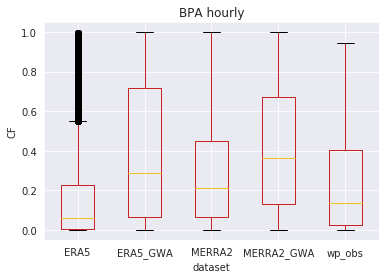

In [27]:
cf_BPAh.boxplot()
plt.xlabel('dataset')
plt.ylabel('CF')
plt.title('BPA hourly')

In [34]:
## BPA daily
# aggregate daily
comp_BPAd = comp_BPAh.resample('D').sum()[1:] # drop first day because incomplete
# calculate capacity factors
cf_BPAd = comp_BPAd.div(cap_BPAd,axis=0).dropna()

In [ ]:
cf_BPAd.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('BPA daily')
plt.savefig(results_path + '/TS_plots/BPAd.png')

Text(0.5, 1.0, 'BPA daily')

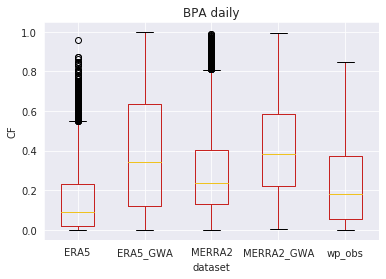

In [32]:
cf_BPAd.boxplot()
plt.xlabel('dataset')
plt.ylabel('CF')
plt.title('BPA daily')

In [36]:
## BPA monthly
# aggregate monthly
comp_BPAm = comp_BPAh.resample('M').sum()
# calculate capacity factors
cf_BPAm = comp_BPAm.div(cap_BPAm,axis=0).dropna()

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


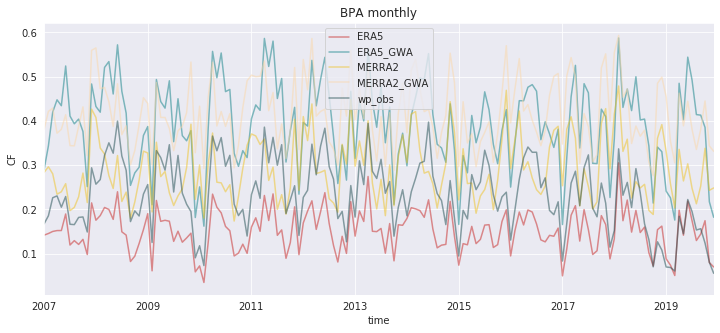

In [37]:
cf_BPAm.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('BPA monthly')
plt.savefig(results_path + '/TS_plots/BPAm.png')

In [38]:
## New England monthly
# Load production data
# Source: https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/sys-load-eei-fmt
# years 2000 - 2015 in one file
for year in range(2000,2016):
    NExl = pd.read_excel(usa_path+"/generation_data/NewEngland_monthly/2000-2015_energy_peak_source.xls",
                         sheet_name = str(year))
    windy = NExl.iloc[np.where(NExl.iloc[:,0]=='Wind')[0][0]][2:14].values
    if 'windally' in globals():
        windally = windally + list(windy)
    else:
        windally = list(windy)
for year in range(2016,2019):
    NExl = pd.read_excel(usa_path+"/generation_data/NewEngland_monthly/"+str(year)+"_energy_peak_by_source.xlsx",
                         sheet_name = str(year))
    windy = NExl.iloc[np.where(NExl.iloc[:,0]=='WIND')[0][0]][1:13].values
    windally = windally + list(windy)
prod_NE = pd.DataFrame({'wp_obs':windally},
                       index = pd.date_range(start='01-01-2000',
                                             end='01-01-2019',
                                             freq='m').values.astype('datetime64[M]').astype('datetime64[s]'))# type of index is changed to get beginning of month
prod_NE = prod_NE.tz_localize('US/Eastern')
# Prepare simulated data
# load data
wp_NEE = xr.open_dataset(results_path+"/windpower_NewEngland_ERA5.nc").to_dataframe()
wp_NEE_GWA = xr.open_dataset(results_pathg+"/windpower_NewEngland_ERA5_GWA.nc").to_dataframe()
wp_NEM = xr.open_dataset(results_path+"/windpower_NewEngland_MERRA2.nc").to_dataframe().resample('h').sum() # resample merra because 2019 different format
wp_NEM_GWA = xr.open_dataset(results_pathg+"/windpower_NewEngland_MERRA2_GWA.nc").to_dataframe().resample('h').sum()
# merge data
comp_NEh = pd.concat([wp_NEE,wp_NEE_GWA,wp_NEM,wp_NEM_GWA],axis=1)
comp_NEh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']
comp_NEm = comp_NEh.tz_localize('UTC').tz_convert('US/Eastern').resample('M').sum()[1:-1] # cut last and first because incomplete
# add production data
comp_NEm['wp_obs'] = comp_NEm.index.map(prod_NE[prod_NE.wp_obs>0].resample('M').mean().wp_obs) * 10**6
comp_NEm = comp_NEm.dropna()
# calculate capacity factor
cf_NEm = comp_NEm.div(comp_NEm.index.map(cap_NEm),axis=0).dropna()

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


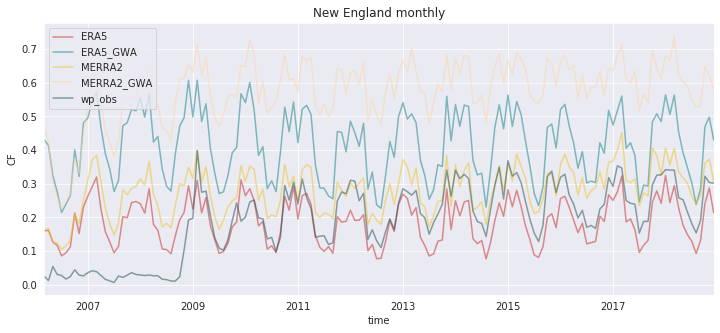

In [39]:
cf_NEm.plot(figsize=(12,5),alpha=0.5)
plt.xlabel('time')
plt.ylabel('CF')
plt.title('New England monthly')
plt.savefig(results_path + '/TS_plots/NEm.png')